In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
# import shap


In [2]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [3]:
data = pd.read_csv('cardio_train1.csv')
# print(data.head())


# # EDA and preproccesing 
# print(data.isna().sum())
X = data.iloc[:, 1:-1]
Y = data.iloc[:, -1]

XX = ['age', 'gender', 'weight', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
YY = ['cardio']

# Split the data into features and target variables
features = data[XX]
targets = data[YY]

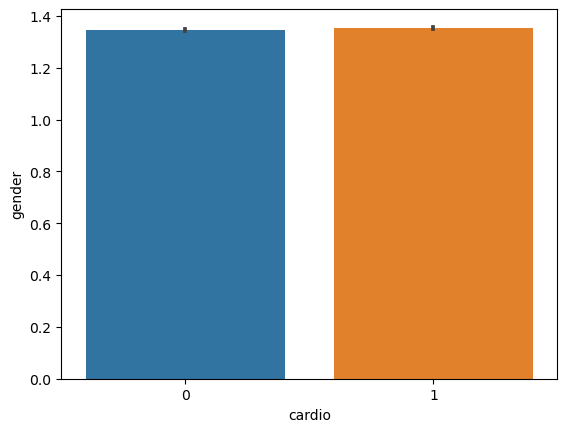

In [4]:
import seaborn as sns
sns.barplot(x="cardio", y="gender", data=data, ci=95);

In [6]:
# Split the data into train and test sets (stratified by sex)
train_features, test_features, train_targets, test_targets = train_test_split(
    features, targets, test_size=0.2, stratify=features[['gender']], random_state=42)

# Split the data into train and test sets (stratified by sex and one outcome variable)
# train_features, test_features, train_targets, test_targets = train_test_split(
#     features, targets, test_size=0.2, stratify=features[['gender']], random_state=42)

In [9]:
test_targets.cardio.value_counts()

0    7001
1    6999
Name: cardio, dtype: int64

In [7]:
# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
# class_weight.compute_class_weight('balanced',n_samples / (n_classes * np.bincount(y)))
# Calculate class weights for handling class imbalance
# class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(train_targets), y= train_targets)
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_targets), train_targets)

In [8]:
# Train and evaluate the models
models = []
from sklearn.metrics import roc_auc_score, f1_score
class_weights = {0: 1, 1: 2.2}
# XGBoost
xgb_model1 = xgb.XGBClassifier()
xgb_model1.fit(train_features_scaled, train_targets['cardio'])
xgb_preds = xgb_model1.predict(test_features_scaled)
print("XGBoost:")
# Evaluate the model performance based on the roc score
roc_auc_xgb = roc_auc_score(test_targets, xgb_preds)
print(f'ROC AUC Score with xgb: {roc_auc_xgb:.2f}')
# print(classification_report(test_targets['cardio'], xgb_preds))
# models.append(xgb_model)

# Random Forest
rf_model = RandomForestClassifier(class_weight=class_weights)
rf_model.fit(train_features_scaled, train_targets['cardio'])
rf_preds = rf_model.predict(test_features_scaled)
print("Random Forest:")
# Evaluate the model performance based on the roc score
roc_auc_rf = roc_auc_score(test_targets, rf_preds)
print(f'ROC AUC Score with rf: {roc_auc_rf:.2f}')
# print(classification_report(test_targets['cardio'], rf_preds))
# models.append(rf_model)

XGBoost:
ROC AUC Score with xgb: 0.74
Random Forest:
ROC AUC Score with rf: 0.69


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(train_features, train_targets)

/Users/kayadetunji/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

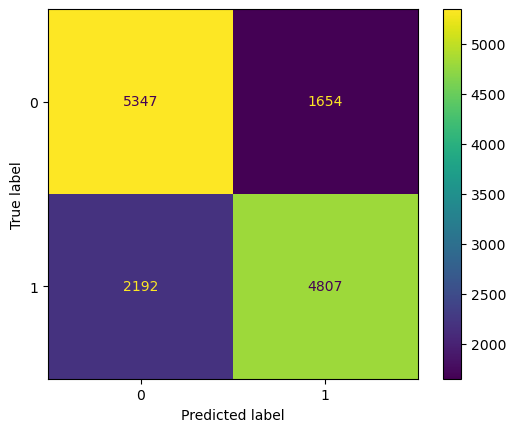

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(test_features)
cm = confusion_matrix(test_targets, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [29]:
y_score

array([-0.63134812, -0.55075166,  1.42475802, ...,  2.88828998,
        0.07642152, -0.27656719])

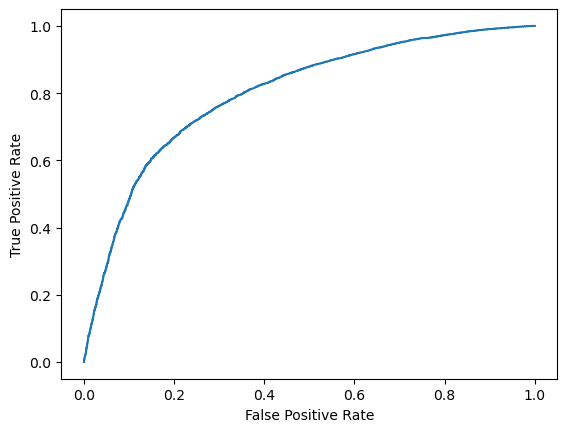

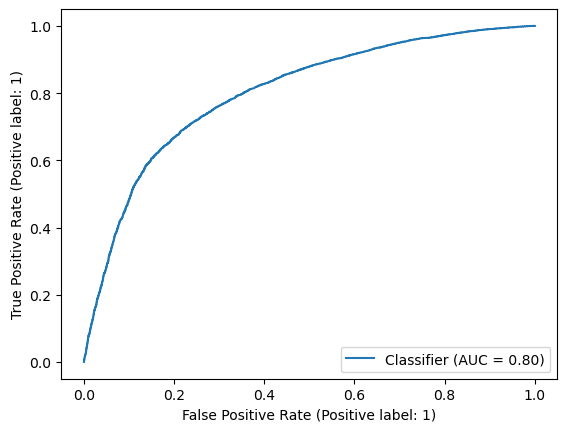

In [31]:
y_score = clf.decision_function(test_features)
xgb_predsprob = xgb_model1.predict_proba(test_features_scaled)[:,1]
fpr, tpr, _ = roc_curve(test_targets, xgb_predsprob, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
RocCurveDisplay.from_predictions(test_targets, xgb_predsprob)

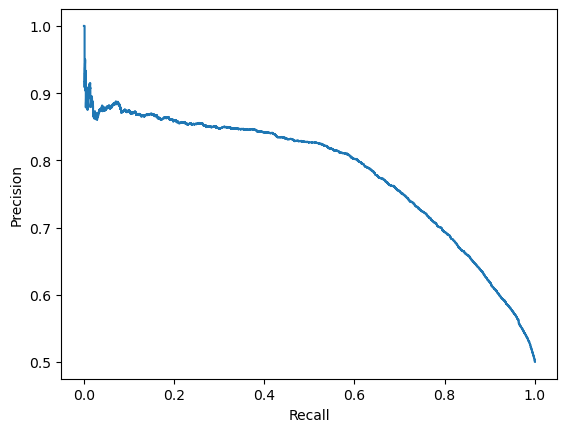

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_targets, xgb_predsprob, pos_label=xgb_model1.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

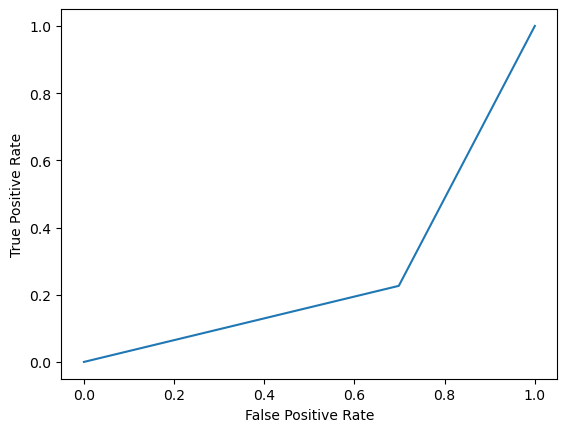

In [11]:
from sklearn.metrics import RocCurveDisplay, roc_curve
fpr, tpr, _ = roc_curve(test_targets, xgb_preds, pos_label=xgb_model1.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
# RocCurveDisplay.from_predictions(test_targets, xgb_preds)

In [12]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

# Train a fairness-aware model using the ExponentiatedGradient algorithm with DemographicParity constraint
sensitive_feature = 'gender'  # Choose the sensitive feature used for fairness considerations
constraint = DemographicParity()
model = xgb.XGBClassifier()
fair_model = ExponentiatedGradient(model, constraint)
fair_model.fit(train_features_scaled, train_targets['cardio'], sensitive_features=train_features[sensitive_feature])

# Evaluate the fairness-aware model
fair_preds = fair_model.predict(test_features_scaled)
print("Fairness-Aware Model:")
print(classification_report(test_targets['cardio'], fair_preds))

# Measure fairness metrics
fairness_report = constraint.evaluate(test_features_scaled, test_targets['cardio'], sensitive_features=test_features[sensitive_feature])
print("Fairness Report:")
print(fairness_report)

# Measure overall accuracy
overall_accuracy = accuracy_score(test_targets['cardio'], fair_preds)
print("Overall Accuracy:", overall_accuracy)


Fairness-Aware Model:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      7001
           1       0.75      0.70      0.73      6999

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.73     14000
weighted avg       0.74      0.74      0.73     14000



AttributeError: 'DemographicParity' object has no attribute 'evaluate'

In [13]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(test_targets.cardio.values,
                                    fair_preds,
                                    sensitive_features=test_features.gender.values))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(test_targets.cardio.values,
                                    fair_preds,
                                    sensitive_features=test_features.gender.values))

0.014972770864443485
0.9681443804926116


In [14]:
from fairlearn.metrics import equalized_odds_difference
print(equalized_odds_difference(test_targets.cardio.values,
                                    fair_preds,
                                    sensitive_features=test_features.gender.values))

from fairlearn.metrics import equalized_odds_ratio
print(equalized_odds_ratio(test_targets.cardio.values,
                                    fair_preds,
                                    sensitive_features=test_features.gender.values))
from fairlearn.metrics import make_derived_metric, MetricFrame
from sklearn.metrics import recall_score
recall_difference = make_derived_metric(metric=recall_score,
                                       transform='difference')
recall_difference(test_targets.cardio.values,
                                    fair_preds,
                                    sensitive_features=test_features.gender.values)
MetricFrame(metrics=recall_score,
            y_true=test_targets.cardio.values,
            y_pred=fair_preds,
            sensitive_features=test_features.gender.values).difference()

0.027205165873368742
0.9616631481524073


0.027205165873368742

In [15]:
import functools
from sklearn.metrics import fbeta_score
fbeta_06 = functools.partial(fbeta_score, beta=0.6)
metric_beta = MetricFrame(metrics=fbeta_06,
                          y_true=test_targets.cardio.values,
                          y_pred=fair_preds,
                          sensitive_features=test_features.gender.values)
# metric_beta.difference()
# metric_beta.by_group
# metric_beta.ratio()
metric_beta.overall

/Users/kayadetunji/opt/anaconda3/lib/python3.9/site-packages/fairlearn/metrics/_annotated_metric_function.py:64: UserWarning: Supplied 'func' had no __name__ attribute
  warnings.warn("Supplied 'func' had no __name__ attribute")


0.7382591972206711

In [16]:
s_w = test_features.smoke.values
s_p = { 'sample_weight':s_w }
weighted = MetricFrame(metrics=recall_score,
                       y_true=test_targets.cardio.values,
                       y_pred=fair_preds,
                       sensitive_features=pd.Series(test_features.gender.values, name='SF 0'),
                       sample_params=s_p)
weighted.overall
weighted.by_group

SF 0
1    0.661765
2    0.685484
Name: recall_score, dtype: float64

In [17]:
s_w_2 = test_features.alco.values
metrics = {
   'recall' : recall_score,
   'recall_weighted' : recall_score,
   'recall_weight_2' : recall_score
}
s_p = {
    'recall_weighted' : { 'sample_weight':s_w },
    'recall_weight_2' : { 'sample_weight':s_w_2 }
}
weighted = MetricFrame(metrics=metrics,
                       y_true=test_targets.cardio.values,
                       y_pred=fair_preds,
                       sensitive_features=pd.Series(test_features.gender.values, name='SF 0'),
                       sample_params=s_p)
weighted.overall

recall             0.700100
recall_weighted    0.682624
recall_weight_2    0.723032
dtype: float64

In [18]:
from sklearn.metrics import confusion_matrix
mf_conf = MetricFrame(
   metrics=confusion_matrix,
   y_true=test_targets.cardio.values,
   y_pred=fair_preds,
   sensitive_features=test_features.gender.values
)
mf_conf.by_group

sensitive_feature_0
1    [[3506, 1054], [1320, 3226]]
2      [[1888, 553], [779, 1674]]
Name: confusion_matrix, dtype: object

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sensitive_feature_0'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sensitive_feature_0'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sensitive_feature_0'>],
       [<AxesSubplot:xlabel='sensitive_feature_0'>,
        <AxesSubplot:xlabel='sensitive_feature_0'>,
        <AxesSubplot:xlabel='sensitive_feature_0'>],
       [<AxesSubplot:xlabel='sensitive_feature_0'>,
        <AxesSubplot:xlabel='sensitive_feature_0'>,
        <AxesSubplot:xlabel='sensitive_feature_0'>]], dtype=object)

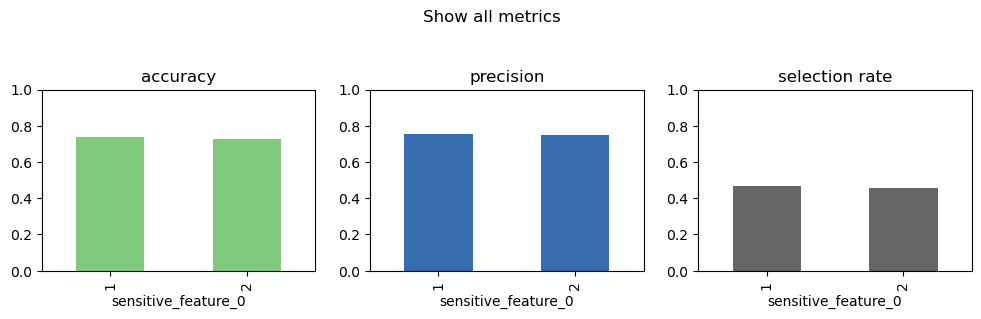

In [19]:
from sklearn.metrics import precision_score
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    # "false positive rate": false_positive_rate,
    # "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    # "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=test_targets.cardio.values, y_pred=fair_preds, sensitive_features=test_features.gender.values
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    ylim=[0, 1],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Show all metrics",
)

In [29]:
train_features.age

32109    18927
24256    17496
25264    18010
1521     15952
46335    19648
         ...  
27548    21680
30181    18198
30737    20169
47126    16578
38312    16626
Name: age, Length: 56000, dtype: int64

In [28]:
from sklearn.metrics import confusion_matrix

# Evaluate the fairness-aware model on the test set
fair_preds = fair_model.predict(test_features_scaled)
# print("Fairness-Aware Model:")
# print(classification_report(test_targets['stroke'], fair_preds))

# Calculate the confusion matrix
confusion = confusion_matrix(test_targets['cardio'], fair_preds)
print("Confusion Matrix:")
print(confusion)

# Identify instances where the model makes mistakes
misclassified_indices = np.where(test_targets['cardio'] != fair_preds)[0]

# Print example misclassified instances
for idx in misclassified_indices[:5]:
    print("Instance:", idx)
    print("Features:", test_features.iloc[idx])
    print("True Label:", test_targets['cardio'].iloc[idx])
    print("Predicted Label:", fair_preds[idx])
    print("--------------------")


Confusion Matrix:
[[5395 1606]
 [2095 4904]]
Instance: 3
Features: age            18173.0
gender             1.0
weight            61.0
ap_hi            150.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
Name: 65138, dtype: float64
True Label: 0
Predicted Label: 1
--------------------
Instance: 7
Features: age            18027.0
gender             2.0
weight            78.0
ap_hi             90.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
Name: 59975, dtype: float64
True Label: 1
Predicted Label: 0
--------------------
Instance: 14
Features: age            18353.0
gender             2.0
weight            79.0
ap_hi            120.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
Name: 36163, dtype: float64
True Label: 1
Predicted Label: 0
--------------------
Instance: 16
Features

In [38]:
# Get feedback from the user for a specific instance
user_feedback_instance = 3  # Choose the index of the instance for user feedback

# Get the user's feedback (e.g., correct label)
user_correct_label = 1  # Choose the correct label provided by the user

# Update the model using the user's feedback
updated_train_features = train_features.copy()
updated_train_features.iloc[user_feedback_instance] = test_features.iloc[user_feedback_instance]  # Replace the instance in the training set with the user-provided instance
updated_train_targets = train_targets.copy()
updated_train_targets['cardio'].iloc[user_feedback_instance] = user_correct_label  # Replace the label in the training set with the user-provided correct label

# Retrain the model with the updated training set
# fair_model1 = ExponentiatedGradient(model, constraint)
# Define the fairness-aware model using the ExponentiatedGradient algorithm with Demographic Parity fairness constraint
fair_model1 = ExponentiatedGradient(
    model,
    constraints=DemographicParity(),
    # epsilon=0.05  # Fairness tolerance parameter
)
fair_model1.fit(scaler.transform(updated_train_features), updated_train_targets['cardio'], sensitive_features=updated_train_features[sensitive_feature])

# Evaluate the updated model
updated_fair_preds = fair_model1.predict(test_features_scaled)
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets['cardio'], updated_fair_preds))
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets['cardio'], fair_preds))
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets['cardio'], xgb_preds))


Updated Fairness-Aware Model:
0.7352805252098067
Updated Fairness-Aware Model:
0.7356378619517931
Updated Fairness-Aware Model:
0.7359231884882284


In [34]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
# Get feedback from the user for a specific instance
user_feedback_instance = 3  # Choose the index of the instance for user feedback

# Get the user's feedback (e.g., correct label)
user_correct_label = 1  # Choose the correct label provided by the user

# Update the model using the user's feedback
updated_train_features = train_features.copy()
updated_train_features.iloc[user_feedback_instance] = test_features.iloc[user_feedback_instance]  # Replace the instance in the training set with the user-provided instance
updated_train_targets = train_targets.copy()
updated_train_targets['cardio'].iloc[user_feedback_instance] = user_correct_label  # Replace the label in the training set with the user-provided correct label

# Retrain the model with the updated training set
# fair_model1 = ExponentiatedGradient(model, constraint)
# Define the fairness-aware model using the ExponentiatedGradient algorithm with Demographic Parity fairness constraint
fair_model1 = ExponentiatedGradient(
    model,
    constraints=DemographicParity(),
    # epsilon=0.05  # Fairness tolerance parameter
)
fair_model1.fit(scaler.transform(updated_train_features), updated_train_targets['cardio'], sensitive_features=updated_train_features[sensitive_feature])

# Evaluate the updated model
updated_fair_preds = fair_model1.predict(test_features_scaled)
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets['cardio'], updated_fair_preds))
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets['cardio'], fair_preds))
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets['cardio'], xgb_preds))


NameError: name 'model' is not defined

In [40]:
# Measure fairness metrics
# fairness_report = constraint.evaluate(test_features_scaled, test_targets['cardio'], sensitive_features=test_features[sensitive_feature])
# print("Fairness Report:")
# print(fairness_report)
constraint
# Measure overall accuracy
overall_accuracy = accuracy_score(test_targets['cardio'], fair_preds)
print(" Fair Overall Accuracy:", overall_accuracy)
overall_accuracy = accuracy_score(test_targets['cardio'], xgb_preds)
print("Overall Accuracy:", overall_accuracy)

 Fair Overall Accuracy: 0.7356428571428572
Overall Accuracy: 0.7359285714285714


In [92]:
model.fit(train_features_scaled, train_targets['cardio'])
model.feature_importances_
initial_preds = model.predict(test_features)

# Perform active learning with user feedback
num_instances_to_query = 5  # Number of instances to query for user feedback

# Select the most uncertain instances from the test set
uncertainty_scores = model.predict_proba(test_features)[:, 1]  # Get the probability of the positive class
most_uncertain_indices = np.argsort(np.abs(uncertainty_scores - 0.5))[:num_instances_to_query]
selected_instances = test_features.iloc[most_uncertain_indices]

# Get user feedback for the selected instances
user_feedback_labels = [0, 1, 0, 1, 0]  # Replace with the user-provided feedback labels for the selected instances

# Incorporate the user feedback into the training set
updated_train_features = pd.concat([train_features, selected_instances])
updated_train_target = pd.concat([train_targets['cardio'], pd.Series(user_feedback_labels)])

# Retrain the XGBoost model with the updated training set
updated_xgb_model = xgb.XGBClassifier()
updated_xgb_model.fit(updated_train_features, updated_train_target)

# Evaluate the updated model on the test set
updated_preds = updated_xgb_model.predict(test_features)
print("XGBoost Model:")
print(accuracy_score(test_targets, xgb_preds))
print("Fair XGBoost Model:")
print(accuracy_score(test_targets, fair_preds))
print("Updated XGBoost Model:")
print(accuracy_score(test_targets, updated_preds))

XGBoost Model:
0.7359285714285714
Fair XGBoost Model:
0.7356428571428572
Updated XGBoost Model:
0.7343571428571428


In [88]:
updated_train_features = train_features.append(selected_instances)
updated_train_targets = train_targets.append(pd.DataFrame({'stroke': user_feedback_labels}, index=selected_instances.index))
updated_train_target = pd.concat([train_targets['cardio'], pd.Series(user_feedback_labels)])
updated_train_target

/var/folders/gv/py_qrkp162g_1kqt0zrs11qc0000gn/T/ipykernel_37138/4159503734.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_train_features = train_features.append(selected_instances)
/var/folders/gv/py_qrkp162g_1kqt0zrs11qc0000gn/T/ipykernel_37138/4159503734.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_train_targets = train_targets.append(pd.DataFrame({'stroke': user_feedback_labels}, index=selected_instances.index))


32109    0
24256    1
25264    1
1521     1
46335    0
        ..
0        0
1        1
2        0
3        1
4        0
Length: 56005, dtype: int64

In [87]:
# test_features.iloc[most_uncertain_indices].shape
pd.concat([train_features, selected_instances]).shape
# np.concatenate([train_targets, user_feedback_labels]
pd.concat([train_targets['cardio'], pd.Series(user_feedback_labels)]).shape

(56005,)

In [1]:
# Import Counterfactuals.
import tensorflow as tf



: 

: 

In [26]:
from lime.lime_tabular import LimeTabularExplainer

# Train an interpretable model
interpretable_model = RandomForestClassifier()
interpretable_model.fit(train_features_scaled, train_targets['cardio'])

# Create an explainer for LIME
explainer_lime = LimeTabularExplainer(train_features.values, feature_names=train_features.columns, class_names=['No CVD', 'CVD'])

# Choose an instance for explanation
instance_idx = 33  # Choose the index of the instance you want to explain

# Generate LIME explanation for the chosen instance
lime_exp = explainer_lime.explain_instance(test_features_scaled[instance_idx], interpretable_model.predict_proba, num_features=len(train_features.columns))

# Print the explanation
lime_exp.show_in_notebook(show_table=True)

In [1]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

# from common_utils import compute_metrics

favorable_label = train_features.gender.unique()[1]
unfavorable_label = train_features.gender.unique()[0]
display(Markdown("##### Favorable and unfavorable labels"))
print(favorable_label, unfavorable_label)

NameError: name 'train_features' is not defined

In [ ]:
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [ ]:
shap.initjs()
explainer = shap.Explainer(xgb_model, train_features_scaled)
shap_values = explainer(test_features_scaled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, train_features_scaled[0,:])